In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# Load and preprocess the data
data = pd.read_csv('2022-09-02.csv')
data


,Unnamed: 0,Freq,Ia,Ib,Ic,PF,UpdateTime,Va,Vb,Vc,...,kWh+,kWh-,kWh_abs,kWh_net,θIA,θIB,θIC,θVA,θVB,θVC
0,0,59.9,2.2,2.0,2.8,0.66,2022-09-02 00:00:28,6832.0,6717.0,6837.0,...,311268.0,0.0,311270.0,311266.0,326.88,64.26,191.73,0.0,120.57,240.55
1,1,59.9,2.4,2.0,2.8,0.66,2022-09-02 00:00:48,6831.0,6712.0,6837.0,...,311268.0,0.0,311270.0,311266.0,327.52,66.49,191.57,0.0,120.65,240.38
2,2,60.0,2.4,2.0,2.8,0.64,2022-09-02 00:01:33,6826.0,6693.0,6827.0,...,311268.0,0.0,311270.0,311268.0,325.71,62.76,187.86,0.0,120.48,240.30
3,3,60.0,2.4,2.0,2.8,0.64,2022-09-02 00:01:54,6825.0,6708.0,6832.0,...,311268.0,0.0,311270.0,311268.0,325.71,64.26,188.95,0.0,120.40,240.30
4,4,59.9,2.4,2.0,2.8,0.65,2022-09-02 00:02:39,6814.0,6679.0,6819.0,...,311270.0,0.0,311270.0,311268.0,325.71,65.03,188.03,0.0,120.65,240.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2564,2564,60.0,2.4,2.0,2.6,0.67,2022-09-02 23:57:26,6803.0,6689.0,6807.0,...,312282.0,0.0,312284.0,312282.0,325.71,67.97,191.39,0.0,120.57,240.38
2565,2565,59.9,2.4,2.0,2.8,0.67,2022-09-02 23:58:11,6803.0,6688.0,6808.0,...,312284.0,0.0,312284.0,312282.0,326.88,67.89,190.35,0.0,120.48,240.55
2566,2566,59.9,2.4,2.0,2.8,0.68,2022-09-02 23:58:31,6801.0,6686.0,6806.0,...,312284.0,0.0,312284.0,312282.0,326.88,66.57,189.38,0.0,120.74,240.72
2567,2567,60.0,2.4,2.0,2.6,0.71,2022-09-02 23:59:17,6804.0,6683.0,6807.0,...,312284.0,0.0,312286.0,312282.0,326.88,70.37,192.86,0.0,120.57,240.46


In [3]:
missing_values = data.isnull().sum()
print(missing_values)


Unnamed: 0    0
Freq          0
Ia            0
Ib            0
Ic            0
PF            0
UpdateTime    0
Va            0
Vb            0
Vc            0
kPt           0
kQt           0
kSt           0
kVARh_Q1      0
kVARh_Q2      0
kVARh_Q3      0
kVARh_Q4      0
kVAh+         0
kVAh-         0
kWh+          0
kWh-          0
kWh_abs       0
kWh_net       0
θIA           0
θIB           0
θIC           0
θVA           0
θVB           0
θVC           0
dtype: int64


In [4]:
# Convert 'UpdateTime' to datetime and set as index
data['UpdateTime'] = pd.to_datetime(data['UpdateTime'])
data.set_index('UpdateTime', inplace=True)
df = data[['kWh+']]

In [5]:
data

,Unnamed: 0,Freq,Ia,Ib,Ic,PF,Va,Vb,Vc,kPt,...,kWh+,kWh-,kWh_abs,kWh_net,θIA,θIB,θIC,θVA,θVB,θVC
UpdateTime,,,,,,,,,,,,,,,,,,,,,
2022-09-02 00:00:28,0,59.9,2.2,2.0,2.8,0.66,6832.0,6717.0,6837.0,32.0,...,311268.0,0.0,311270.0,311266.0,326.88,64.26,191.73,0.0,120.57,240.55
2022-09-02 00:00:48,1,59.9,2.4,2.0,2.8,0.66,6831.0,6712.0,6837.0,32.0,...,311268.0,0.0,311270.0,311266.0,327.52,66.49,191.57,0.0,120.65,240.38
2022-09-02 00:01:33,2,60.0,2.4,2.0,2.8,0.64,6826.0,6693.0,6827.0,32.0,...,311268.0,0.0,311270.0,311268.0,325.71,62.76,187.86,0.0,120.48,240.30
2022-09-02 00:01:54,3,60.0,2.4,2.0,2.8,0.64,6825.0,6708.0,6832.0,32.0,...,311268.0,0.0,311270.0,311268.0,325.71,64.26,188.95,0.0,120.40,240.30
2022-09-02 00:02:39,4,59.9,2.4,2.0,2.8,0.65,6814.0,6679.0,6819.0,32.0,...,311270.0,0.0,311270.0,311268.0,325.71,65.03,188.03,0.0,120.65,240.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-02 23:57:26,2564,60.0,2.4,2.0,2.6,0.67,6803.0,6689.0,6807.0,32.0,...,312282.0,0.0,312284.0,312282.0,325.71,67.97,191.39,0.0,120.57,240.38
2022-09-02 23:58:11,2565,59.9,2.4,2.0,2.8,0.67,6803.0,6688.0,6808.0,32.0,...,312284.0,0.0,312284.0,312282.0,326.88,67.89,190.35,0.0,120.48,240.55
2022-09-02 23:58:31,2566,59.9,2.4,2.0,2.8,0.68,6801.0,6686.0,6806.0,32.0,...,312284.0,0.0,312284.0,312282.0,326.88,66.57,189.38,0.0,120.74,240.72


In [6]:
# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

In [7]:
# Create sequences for LSTM
def create_sequences(data, sequence_length, forecast_horizon):
    X, y = [], []
    for i in range(len(data) - sequence_length - forecast_horizon):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length:i + sequence_length + forecast_horizon])
    return np.array(X), np.array(y)

sequence_length = 60
forecast_horizon = 10
X, y = create_sequences(scaled_data, sequence_length, forecast_horizon)

In [8]:
# Split into training and validation sets
split = int(X.shape[0] * 0.8)
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

In [9]:
# Build the LSTM model
model = Sequential([
    LSTM(128, activation='relu', input_shape=(sequence_length, 1), return_sequences=True),
    Dropout(0.2),
    LSTM(64, activation='relu'),
    Dropout(0.2),
    Dense(forecast_horizon)
])

model.compile(optimizer='adam', loss='mse')


C:\Users\Usama Zafar\Desktop\AI_Course\ml_project\LSTM\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 186ms/step - loss: 0.0764 - val_loss: 0.0059
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - loss: 0.0061 - val_loss: 0.0034
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - loss: 0.0045 - val_loss: 4.4460e-04
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - loss: 0.0042 - val_loss: 4.2136e-04
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - loss: 0.0037 - val_loss: 2.8727e-04
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - loss: 0.0029 - val_loss: 6.3055e-04
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - loss: 0.0030 - val_loss: 1.9207e-04
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - loss: 0.0027 - val_loss: 3.0078e-05
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - loss: 0.0022 - val_loss: 2.8141e-05
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - loss: 0.0023 - val_loss: 6.2220e-05
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - loss: 0.0021 - val_loss: 6.1299e-05
Epoch 12/20
63

In [11]:
# Make predictions on the validation set
predictions = model.predict(X_val)
predictions

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step


array([[0.81841445, 0.82050335, 0.8186134 , ..., 0.8217002 , 0.8228311 ,
        0.82519925],
       [0.8188808 , 0.8209728 , 0.81907904, ..., 0.8221678 , 0.82329446,
        0.8256698 ],
       [0.81937313, 0.82146895, 0.8195709 , ..., 0.8226629 , 0.82378465,
        0.82616746],
       ...,
       [0.9615158 , 0.9649451 , 0.961884  , ..., 0.9653541 , 0.9652915 ,
        0.97016084],
       [0.9617634 , 0.9651954 , 0.9621316 , ..., 0.9656023 , 0.9655373 ,
        0.970412  ],
       [0.96199346, 0.96542776, 0.9623622 , ..., 0.965832  , 0.9657652 ,
        0.97064525]], dtype=float32)

In [12]:
# Assuming predictions and y_val are 3D arrays
predictions_reshaped = predictions.reshape(-1, predictions.shape[-1])  # Reshape to (n_samples * sequence_length, n_features)
y_val_reshaped = y_val.reshape(-1, y_val.shape[-1])  # Similar reshaping

# Now apply inverse_transform
predictions_rescaled = scaler.inverse_transform(predictions_reshaped)
y_val_rescaled = scaler.inverse_transform(y_val_reshaped)


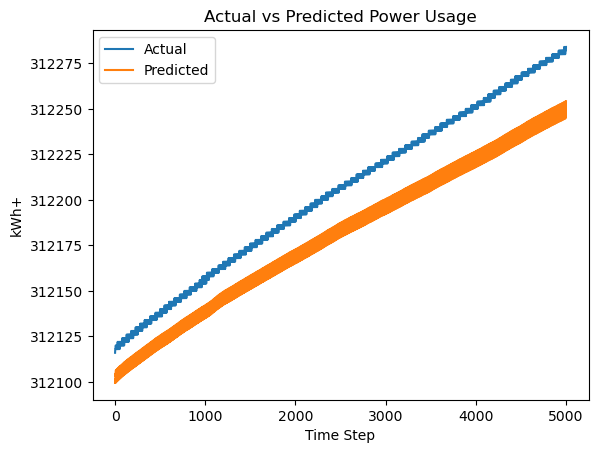

In [13]:
plt.plot(y_val_rescaled.flatten(), label='Actual')
plt.plot(predictions_rescaled.flatten(), label='Predicted')
plt.title('Actual vs Predicted Power Usage')
plt.xlabel('Time Step')
plt.ylabel('kWh+')
plt.legend()
plt.show()

In [14]:
# Calculate Mean Absolute Percentage Error (MAPE) for rescaled values 
mape = np.mean(np.abs((y_val_rescaled - predictions_rescaled.flatten()) / y_val_rescaled)) * 100

# Calculate accuracy as a percentage
accuracy = 100 - mape

# Print the evaluation metrics
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")

Mean Absolute Percentage Error (MAPE): 0.02%
Accuracy: 99.98%


In [15]:
# Calculate Mean Absolute Percentage Error (MAPE) for Scaled Values
mape = np.mean(np.abs((y_val - predictions.flatten()) / y_val)) * 100

# Calculate accuracy as a percentage
accuracy = 100 - mape

# Print the evaluation metrics
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")

Mean Absolute Percentage Error (MAPE): 5.76%
Accuracy: 94.24%
